# 线性回归的从零开始实现

从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [182]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$w=[2, -3.4]^T$、$b=4.2$和噪声项$\epsilon$生成数据集及其标签：

$$
y = Xw + b + \epsilon
$$

In [183]:
def synthetic_data(w, b, num_examples):
    """
    生成 y= Xw + b + 噪声
    :param w: 真实参数w
    :param b: 真实参数b
    :param num_examples: 生成样本数量
    :return: 原始数据：特征、标签
    """
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.1, y.shape)
    return X, y.reshape((-1, 1))


true_w = torch.tensor(([2, -3.4]))
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 10000)

`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一个以为标签值（一个标量）

In [184]:
print('features: ', features[0], '\nlabel:', labels[0])

features:  tensor([-0.9984, -0.3257]) 
label: tensor([3.2617])


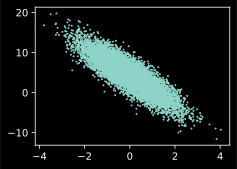

In [185]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个`data_iter`函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [186]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成样本数量个下标索引
    random.shuffle(indices)  # 将样本数量个下标索引打乱
    for i in range(0, num_examples, batch_size):  # 从0开始到样本数量进行遍历，步长为批量大小
        # 将乱序的下标索引每次截取批量大小个小标，作为这一批次数据的索引
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 每次返回一个 特征X 和一个 标签y


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0368, -0.9141],
        [ 0.3228, -2.1867],
        [-0.2292, -0.0727],
        [-0.6057, -0.1077],
        [-0.8306, -1.0030],
        [-1.3733, -0.4783],
        [-0.0093,  0.6825],
        [-1.1082, -0.6837],
        [-0.0525, -1.2160],
        [-0.4015, -0.2613]]) 
 tensor([[ 9.3440],
        [12.3798],
        [ 3.7480],
        [ 3.3814],
        [ 5.9510],
        [ 3.2046],
        [ 2.1211],
        [ 4.2021],
        [ 8.2955],
        [ 4.5739]])


定义初始化模型参数

In [187]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [188]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [189]:
def squared_loss(y_hat, y):
    """均方误差损失函数"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [190]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [191]:
lr = 0.003
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # X 和 y 的小批量损失
        # 因为 l 形状是 (batch_size, 1)，而不是一个标量，l 中的所有元素被追加到，并以此计算关于 [w, b] 的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043873
epoch 2, loss 0.005134
epoch 3, loss 0.005052


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [192]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([0.0006, 0.0007], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)


# 简单实现